In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns; sns.set_style("whitegrid")
import scanpy
import scipy
import scipy.stats as ss
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cross_decomposition import CCA
from sklearn.cluster import AgglomerativeClustering
import leidenalg as la
import igraph as ig
import networkx as nx
import glob
import os
from tqdm import tqdm
from src.grn import grn

from matplotlib import font_manager as fm
fm.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

sns.set_style(None);

%matplotlib inline

# Data Loading

## Perturb-seq

In [2]:
root = '../../../../data/GWPS-Replogle'

norm_sc = os.path.join(root, 'processed', 'K562_gwps_normalized_singlecell_01.h5ad')
sc = scanpy.read_h5ad(norm_sc, backed='r')

pvalues = pd.read_csv(os.path.join(root, 
                                   'supplement', 
                                   'anderson-darling p-values, BH-corrected.csv.gz'),
                      index_col=0)

# guides and genes to keep, cf. Fig1 notebook
remove = ['8769_ELOB_P1P2_ENSG00000103363','5047_MIA2_P1P2_ENSG00000150527','8535_BHLHE40_P1P2_ENSG00000134107']

guides, genes = zip(*[(g,g.split('_')[-1]) for g in sc.obs.loc[sc.obs.gene_id != "non-targeting", "gene_transcript"].unique() 
                      if 'P1' in g.split('_')[2] and g.split('_')[-1] in pvalues.index and g not in remove])

cell_ix = np.where(sc.obs.gene_transcript.isin(guides))[0]
gene_ix = np.where(sc.var.index.isin(genes))[0]
p_ctrls = (sc.obs.gene_id == 'non-targeting').sum() / len(cell_ix)

len(cell_ix), len(gene_ix), p_ctrls

(932593, 5247, 0.08077264144165783)

## Simulations

In [3]:
home = '../../../../projects/genetwork/grn-paper/'
networks = pd.read_csv(home+'networks.tsv', sep='\t', index_col=0)

# in this matrix, rows are KOs and columns are genes: (i,j) is the effect KO i has on gene j
ko = np.load(home + 'ko.npy', mmap_mode='r')
rna = np.load(home + 'rna.npy', mmap_mode='r')
edge = np.load(home + 'beta.npy', mmap_mode='r')
module = np.load(home + 'module.npy', mmap_mode='r')
degrade = np.load(home + 'degrade.npy', mmap_mode='r')

ixs = [678, 707, 647, 677]
display(networks.loc[ixs,:])

,files,n,k,r,delta_in,delta_out,w
678,/oak/stanford/groups/pritch/users/magu/project...,2000,10,4.0,100.0,3.0,900.0
707,/oak/stanford/groups/pritch/users/magu/project...,2000,10,4.0,300.0,3.0,400.0
647,/oak/stanford/groups/pritch/users/magu/project...,2000,10,4.0,30.0,3.0,400.0
677,/oak/stanford/groups/pritch/users/magu/project...,2000,10,4.0,100.0,3.0,400.0


In [4]:
# read in this specific network
ix=ixs[0]

G = nx.read_gpickle(home + 'grns/graph.{}.gpickle'.format(ix)
                   ).set_rna_observation_model(lambda x: x[0, np.arange(0, x.shape[1], 1), :])

group={ix:np.array([G.groups[i] for i in range(G.number_of_nodes())])}

In [5]:
# each of these blocks takes about 45 minutes
sim=False
n_cells = (sc.obs.gene_id == 'non-targeting').sum()
n_perts = int(np.ceil(n_cells * (1-p_ctrls)))
n_ctrls = int(np.floor(n_perts * p_ctrls / (1 - p_ctrls)))
n_cells = n_perts + n_ctrls
print(n_perts + n_ctrls)

for s in [1e0, 1e-1, 1e-2, 1e-3, 1e-4]:
    fname = 'figdata/fig7.baseline_cells.{0}.{1}.npy'.format(ix,s)
    if sim or not os.path.exists(fname):
        print(fname)
        big_rna = G.simulate_rna(x0 = rna[ix-1, :], s = s, tmax = n_cells + 2, burnin=0, step=999999999, save=False)
        np.save(fname, big_rna[s])
    else:
        big_rna = np.load(fname)
    
    fname = 'figdata/fig7.baseline_cells.{0}.{1}.2.npy'.format(ix, s)
    if sim or not os.path.exists(fname):
        print(fname)
        big_rna2 = G.simulate_rna(x0 = rna[ix-1, :], s = s, tmax = n_cells + 2, burnin=0, step=999999999, save=False)
        np.save(fname, big_rna2)
    else:
        big_rna2 = np.load(fname)
    
    fname='figdata/fig7.ko_cells.{0}.{1}.npy'.format(ix,s)
    if sim or not os.path.exists(fname):
        print(fname)
        all_rna = np.vstack([big_rna[np.random.choice(big_rna.shape[0], n_ctrls, replace=False),:]] + \
                            [G.perturb(new_alpha = G.alpha,
                                       new_beta = (np.eye(2000) - np.hstack([np.zeros((2000,i)), 
                                                                             np.eye(2000)[i].reshape(-1,1),
                                                                             np.zeros((2000,2000-i-1))])
                                                  ) @ G.beta,
                                       new_l = G.l,
                                       x0 = rna[ix-1,:] * (2**ko[ix-1,i,:]), 
                                       s = s,
                                       tmax = n + 12, 
                                       burnin = 10, 
                                       step = 999999999) 
                             for i,n in tqdm(enumerate(np.random.multinomial(n=n_perts, pvals=np.ones(2000)/2000)), total=2000)
                            ])
        np.save(fname, all_rna)
    else:
        all_rna = np.load(fname)
    
    fname='figdata/fig7.ko_cells.{0}.{1}.2.npy'.format(ix, s)
    if sim or not os.path.exists(fname):
        print(fname)
        all_rna2 = np.vstack([big_rna2[np.random.choice(big_rna2.shape[0], n_ctrls, replace=False),:]] + \
                             [G.perturb(new_alpha = G.alpha,
                                        new_beta = (np.eye(2000) - np.hstack([np.zeros((2000,i)), 
                                                                              np.eye(2000)[i].reshape(-1,1),
                                                                              np.zeros((2000,2000-i-1))])
                                                   ) @ G.beta,
                                        new_l = G.l,
                                        x0 = rna[ix-1,:] * (2**ko[ix-1,i,:]), 
                                        s = s, 
                                        tmax = n + 12, 
                                        burnin = 10, 
                                        step = 999999999) 
                              for i,n in tqdm(enumerate(np.random.multinomial(n=n_perts, pvals=np.ones(2000)/2000)), total=2000)
                             ])
        np.save(fname, all_rna2)
    else:
        all_rna2 = np.load(fname)
    
all_rna[1].shape, big_rna[1].shape

75328


((2000,), (2000,))

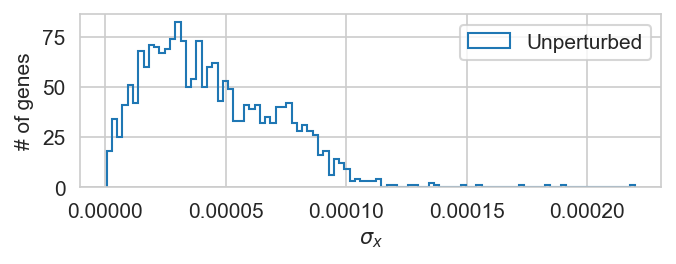

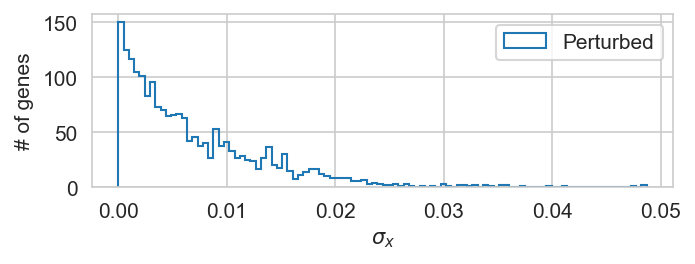

In [6]:
for x, label in zip([big_rna, all_rna], ['Unperturbed','Perturbed']):
    plt.figure(figsize=(5,1.5), dpi=150);
    plt.hist(x.std(axis=0), bins=100, histtype='step', label=label);
    plt.xlabel(r'$\sigma_x$'); plt.ylabel('# of genes'); plt.legend();
    plt.show();

# Dimensionality reduction (TSVD)

In [7]:
n_components=200

## Perturb-seq

### Control cells ("non-targeting")

In [8]:
# (t)SVD on non-targeting (control) cells
if not os.path.exists('figdata/fig7.replogle.ctrl.tsvd.npz'):
    X = sc.chunk_X(np.where(sc.obs.gene_id=='non-targeting')[0])[:,gene_ix]
    Z = np.nan_to_num(X, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
    print(Z.shape)
    
    tsvd = TruncatedSVD(n_components=n_components)
    ps_ctrl_U = tsvd.fit_transform(Z)
    ps_ctrl_D = tsvd.explained_variance_
    ps_ctrl_V = tsvd.components_.T

    np.savez('figdata/fig7.replogle.ctrl.tsvd.npz', U=ps_ctrl_U, D=ps_ctrl_D, V=ps_ctrl_V)
else:
    z = np.load('figdata/fig7.replogle.ctrl.tsvd.npz')
    ps_ctrl_U = z['U']
    ps_ctrl_D = z['D']
    ps_ctrl_V = z['V']

# (t)SVD on downsample of all cells -- THESE VALUES ARE ALREADY NORMALIZED
n_ctrl_cells = (sc.obs.gene_id == 'non-targeting').sum()
if not os.path.exists('figdata/fig7.replogle.ds1.tsvd.npz'):
    cells = np.sort(np.random.choice(cell_ix, size=(n_ctrl_cells,), replace=False))
    #X = sc.X[cells, gene_ix].copy()
    X = sc.chunk_X(cells)[:,gene_ix]
    Z = np.nan_to_num(X, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
    print(Z.shape)
    
    tsvd = TruncatedSVD(n_components=n_components)
    ps_ds1_U = tsvd.fit_transform(Z)
    ps_ds1_D = tsvd.explained_variance_
    ps_ds1_V = tsvd.components_.T

    np.savez('figdata/fig7.replogle.ds1.tsvd.npz', U=ps_ds1_U, D=ps_ds1_D, V=ps_ds1_V, ix=cells)
else:
    z = np.load('figdata/fig7.replogle.ds1.tsvd.npz')
    ps_ds1_U = z['U']
    ps_ds1_D = z['D']
    ps_ds1_V = z['V']

# replicate downsample
if not os.path.exists('figdata/fig7.replogle.ds2.tsvd.npz'):
    cells2 = np.sort(np.random.choice(cell_ix, size=(n_ctrl_cells,), replace=False))
    #X2 = sc.X[cells2, gene_ix].copy()
    X2 = sc.chunk_X(cells2)[:,gene_ix]
    Z2 = np.nan_to_num(X2, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
    print(Z2.shape)
    
    tsvd = TruncatedSVD(n_components=n_components)
    ps_ds2_U = tsvd.fit_transform(Z2)
    ps_ds2_D = tsvd.explained_variance_
    ps_ds2_V = tsvd.components_.T

    np.savez('figdata/fig7.replogle.ds2.tsvd.npz', U=ps_ds2_U, D=ps_ds2_D, V=ps_ds2_V, ix=cells2)
else:
    z = np.load('figdata/fig7.replogle.ds2.tsvd.npz')
    ps_ds2_U = z['U']
    ps_ds2_D = z['D']
    ps_ds2_V = z['V']

# downsamples of various sizes
for n_ds in [1e4, 3e4, 1e5, 3e5, len(cell_ix)]:
    fn = 'figdata/fig7.replogle.sup_ds.{}.tsvd.npz'.format(int(n_ds))
    if not os.path.exists(fn):
        ix_ds = np.sort(np.random.choice(cell_ix, size=int(n_ds), replace=False))
        xx_ds = sc.chunk_X(ix_ds)[:,gene_ix]
        zz_ds = np.nan_to_num(xx_ds, copy=True, nan=0.0, posinf=0.0, neginf=0.0)
        print(zz_ds.shape)
        t = TruncatedSVD(n_components=n_components)
        uu_ds = t.fit_transform(zz_ds)
        dd_ds = t.explained_variance_
        vv_ds = t.components_.T
        np.savez(fn, U=uu_ds, D=dd_ds, V=vv_ds, ix=ix_ds)

display(ps_ctrl_U.shape, ps_ctrl_V.shape, ps_ds1_U.shape, ps_ds1_V.shape, ps_ds2_U.shape, ps_ds2_V.shape)

(75328, 200)

(5247, 200)

(75328, 200)

(5247, 200)

(75328, 200)

(5247, 200)

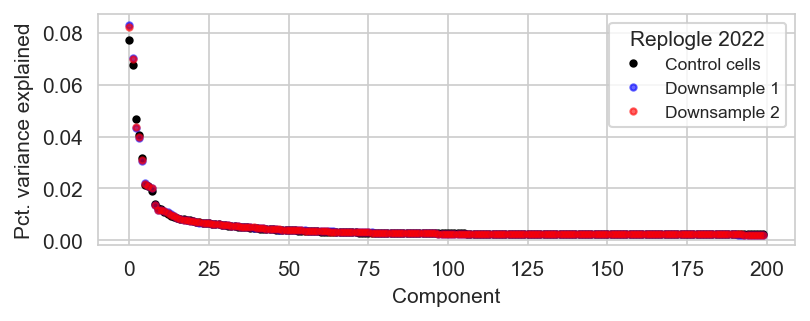

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)

ax.plot(np.arange(n_components), ps_ctrl_D/np.sum(ps_ctrl_D), 'k.', label='Control cells');
ax.plot(np.arange(n_components), ps_ds1_D/np.sum(ps_ds1_D), 'b.', alpha=0.6, label='Downsample 1');
ax.plot(np.arange(n_components), ps_ds2_D/np.sum(ps_ds2_D), 'r.', alpha=0.6, label='Downsample 2');
ax.set_xlabel('Component'); 
ax.set_ylabel('Pct. variance explained'); 
ax.legend(fontsize='small', title='Replogle 2022');

## Simulated Data

In [10]:
## baseline only 
run=False

for s in [1e0, 1e-1, 5e-2, 3e-2, 1e-2, 1e-3, 1e-4]:
    big_rna =  np.load('figdata/fig7.baseline_cells.{0}.{1}.npy'.format(ix, s))
    big_rna2 = np.load('figdata/fig7.baseline_cells.{0}.{1}.2.npy'.format(ix, s))
    all_rna =  np.load('figdata/fig7.ko_cells.{0}.{1}.npy'.format(ix, s))
    all_rna2 = np.load('figdata/fig7.ko_cells.{0}.{1}.2.npy'.format(ix, s))
    
    if run or not os.path.exists('figdata/fig7.baseline_cells.{0}.{1}.tsvd.npz'.format(ix, s)):
        # tsvd
        tsvd = TruncatedSVD(n_components=n_components)
        Z = (big_rna - big_rna.mean(axis=0)) / big_rna.std(axis=0)
        sim_base_U = tsvd.fit_transform(Z)
        sim_base_D = tsvd.explained_variance_
        sim_base_V = tsvd.components_.T
    
        np.savez('figdata/fig7.baseline_cells.{0}.{1}.tsvd.npz'.format(ix, s), U=sim_base_U, D=sim_base_D, V=sim_base_V)
    else:
        z = np.load('figdata/fig7.baseline_cells.{0}.{1}.tsvd.npz'.format(ix, s))
        sim_base_U = z['U']
        sim_base_D = z['D']
        sim_base_V = z['V']
    
    ## baseline only (2)
    if run or not os.path.exists('figdata/fig7.baseline_cells.{0}.{1}.2.tsvd.npz'.format(ix, s)):
        # tsvd
        tsvd = TruncatedSVD(n_components=n_components)
        Z = (big_rna2 - big_rna2.mean(axis=0)) / big_rna2.std(axis=0)
        sim_base_U2 = tsvd.fit_transform(Z)
        sim_base_D2 = tsvd.explained_variance_
        sim_base_V2 = tsvd.components_.T
    
        np.savez('figdata/fig7.baseline_cells.{0}.{1}.2.tsvd.npz'.format(ix, s), U=sim_base_U2, D=sim_base_D2, V=sim_base_V2)
    else:
        z = np.load('figdata/fig7.baseline_cells.{0}.{1}.2.tsvd.npz'.format(ix, s))
        sim_base_U2 = z['U']
        sim_base_D2 = z['D']
        sim_base_V2 = z['V']
    
    
    ## baseline + perturb-seq
    if run or not os.path.exists('figdata/fig7.ko_cells.{0}.{1}.tsvd.npz'.format(ix, s)):
        tsvd = TruncatedSVD(n_components=n_components)
        Z = (all_rna - all_rna.mean(axis=0)) / all_rna.std(axis=0)
        sim_ps_U = tsvd.fit_transform(Z)
        sim_ps_D = tsvd.explained_variance_
        sim_ps_V = tsvd.components_.T
        np.savez('figdata/fig7.ko_cells.{0}.{1}.tsvd.npz'.format(ix, s), U=sim_ps_U, D=sim_ps_D, V=sim_ps_V)
    else:
        z = np.load('figdata/fig7.ko_cells.{0}.{1}.tsvd.npz'.format(ix, s))
        sim_ps_U = z['U']
        sim_ps_D = z['D']
        sim_ps_V = z['V']
    
    ## baseline + perturb-seq (2)
    if run or not os.path.exists('figdata/fig7.ko_cells.{0}.{1}.2.tsvd.npz'.format(ix, s)):
        tsvd = TruncatedSVD(n_components=n_components)
        Z = (all_rna2 - all_rna2.mean(axis=0)) / all_rna2.std(axis=0)
        sim_ps_U2 = tsvd.fit_transform(Z)
        sim_ps_D2 = tsvd.explained_variance_
        sim_ps_V2 = tsvd.components_.T
        np.savez('figdata/fig7.ko_cells.{0}.{1}.2.tsvd.npz'.format(ix, s), U=sim_ps_U2, D=sim_ps_D2, V=sim_ps_V2)
    else:
        z = np.load('figdata/fig7.ko_cells.{0}.{1}.2.tsvd.npz'.format(ix, s))
        sim_ps_U2 = z['U']
        sim_ps_D2 = z['D']
        sim_ps_V2 = z['V']

display(sim_base_U.shape, sim_base_V.shape, sim_ps_U.shape, sim_ps_V.shape)

(75328, 200)

(2000, 200)

(75328, 200)

(2000, 200)

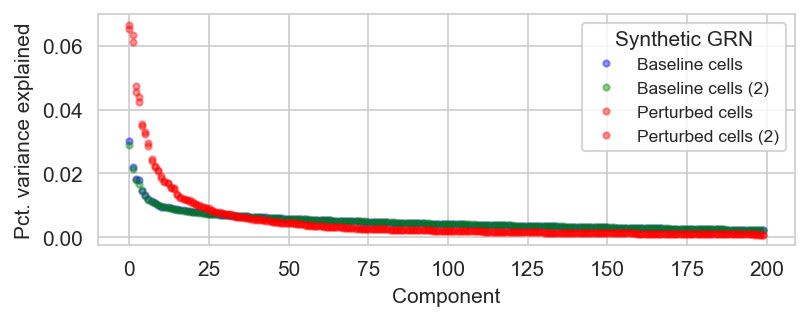

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,2), dpi=150)

ax.plot(np.arange(n_components), sim_base_D/np.sum(sim_base_D), 'b.', alpha=0.4, label='Baseline cells');
ax.plot(np.arange(n_components), sim_base_D2/np.sum(sim_base_D2), 'g.', alpha=0.4, label='Baseline cells (2)');
ax.plot(np.arange(n_components), sim_ps_D/np.sum(sim_ps_D), 'r.', alpha=0.4, label='Perturbed cells');
ax.plot(np.arange(n_components), sim_ps_D2/np.sum(sim_ps_D2), 'r.', alpha=0.4, label='Perturbed cells (2)');
ax.set_xlabel('Component'); 
ax.set_ylabel('Pct. variance explained'); 
ax.legend(fontsize='small', title='Synthetic GRN');

# Figure 7

In [12]:
s = 0.03
z1 = np.load('figdata/fig7.baseline_cells.{0}.{1}.tsvd.npz'.format(ix, s))
sim_base_U = z1['U']
sim_base_D = z1['D']
sim_base_V = z1['V']
    
z2 = np.load('figdata/fig7.baseline_cells.{0}.{1}.2.tsvd.npz'.format(ix, s))
sim_base_U2 = z2['U']
sim_base_D2 = z2['D']
sim_base_V2 = z2['V']
    
z3 = np.load('figdata/fig7.ko_cells.{0}.{1}.tsvd.npz'.format(ix, s))
sim_ps_U = z3['U']
sim_ps_D = z3['D']
sim_ps_V = z3['V']
    
z4 = np.load('figdata/fig7.ko_cells.{0}.{1}.2.tsvd.npz'.format(ix, s))
sim_ps_U2 = z4['U']
sim_ps_D2 = z4['D']
sim_ps_V2 = z4['V']

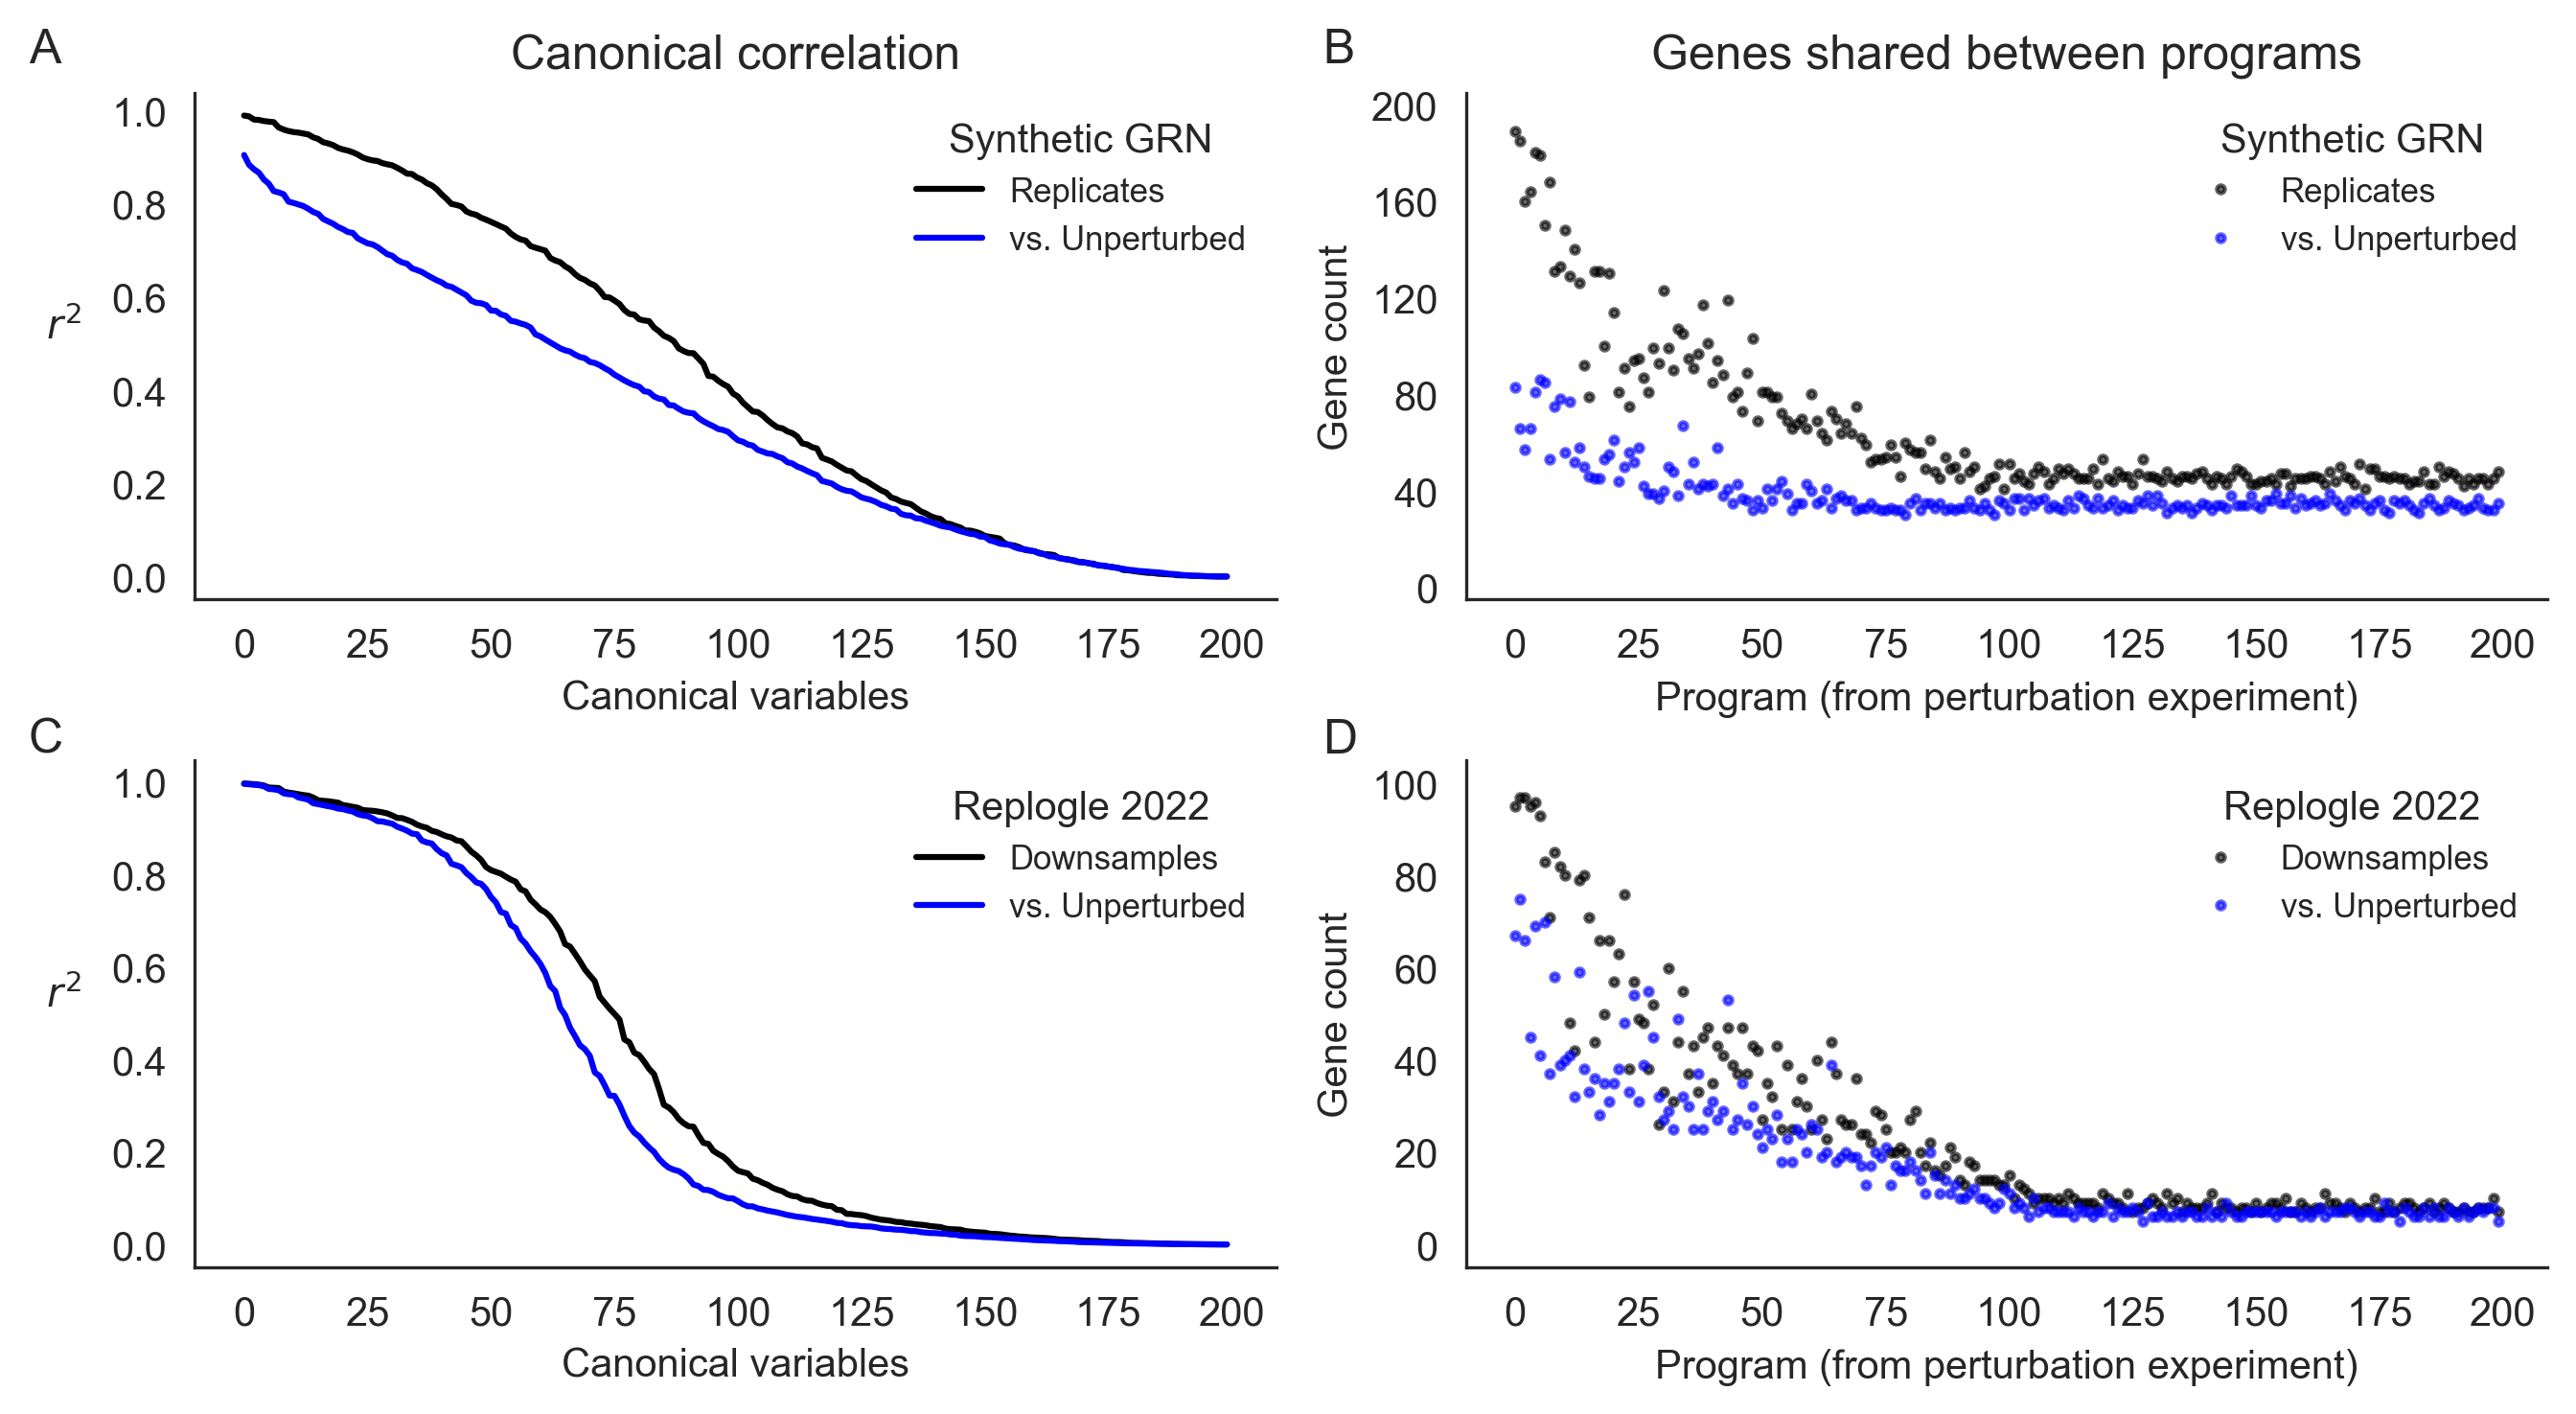

In [13]:
sns.set_style('white'); 

fig = plt.figure(figsize=(9,5), dpi=300)

grid = gs.GridSpec(4, 8, figure=fig)

npc=100

ax0 = fig.add_subplot(grid[0:2,0:4])
ax0.plot(*zip(*enumerate(np.linalg.svd(sim_ps_V.T.dot(sim_ps_V2), 0)[1]**2)), 'k-',
        label='Replicates')
ax0.plot(*zip(*enumerate(np.linalg.svd(sim_ps_V.T.dot(sim_base_V), 0)[1]**2)), 'b-',
        label='vs. Unperturbed')
ax0.legend(fontsize='small', title='Synthetic GRN', frameon=False);
ax0.set_xlabel('Canonical variables'); 
ax0.set_ylabel(r'$r^2$', rotation=0, labelpad=12);

ax1 = fig.add_subplot(grid[2:4,0:4])
ax1.plot(*zip(*enumerate(np.linalg.svd(ps_ds1_V.T.dot(ps_ds2_V), 0)[1]**2)), 'k-', 
        label='Downsamples')
ax1.plot(*zip(*enumerate(np.linalg.svd(ps_ds1_V.T.dot(ps_ctrl_V), 0)[1]**2)), 'b-', 
        label='vs. Unperturbed')
ax1.legend(fontsize='small', title='Replogle 2022', frameon=False);
ax1.set_xlabel('Canonical variables'); 
ax1.set_ylabel(r'$r^2$', rotation=0, labelpad=12);


k = int(2000/networks.loc[ix,'k'])
ax = [None,None]
ax[0] = fig.add_subplot(grid[0:2,4:8])
prog_genes50_b1 = np.argpartition(sim_base_V**2, -k, axis=0)[-k:,:]
prog_genes50_b2 = np.argpartition(sim_base_V2**2, -k, axis=0)[-k:,:]
prog_genes50_p1 = np.argpartition(sim_ps_V**2, -k, axis=0)[-k:,:]
prog_genes50_p2 = np.argpartition(sim_ps_V2**2, -k, axis=0)[-k:,:]

ax[0].plot(*zip(*enumerate([max([len(set(prog_genes50_p1[:,i]) & set(prog_genes50_p2[:,j])) for j in range(n_components)]) for i in range(n_components)])), 
           'k.', alpha=0.6, ms=4, label='Replicates');
ax[0].plot(*zip(*enumerate([max([len(set(prog_genes50_p1[:,i]) & set(prog_genes50_b1[:,j])) for j in range(n_components)]) for i in range(n_components)])), 
           'b.', alpha=0.6, ms=4, label='vs. Unperturbed');
ax[0].set_xlabel('Program (from perturbation experiment)');
ax[0].set_ylabel('Gene count');
ax[0].legend(fontsize='small', title='Synthetic GRN', frameon=False);
ax[0].set_ylim(-5,k+5); ax[0].set_yticks(np.arange(0, k + 1, (k + 1) // 5));

k=100
prog_genes50_p1 = np.argpartition(ps_ds1_V**2, -k, axis=0)[-k:,:]
prog_genes50_p2 = np.argpartition(ps_ds2_V**2, -k, axis=0)[-k:,:]
prog_genes50_b1 = np.argpartition(ps_ctrl_V**2, -k, axis=0)[-k:,:]

ax[1] = fig.add_subplot(grid[2:4,4:8])
ax[1].plot(*zip(*enumerate([max([len(set(prog_genes50_p1[:,i]) & set(prog_genes50_p2[:,j])) for j in range(n_components)]) for i in range(n_components)])), 
           'k.', alpha=0.6, ms=4, label='Downsamples');
ax[1].plot(*zip(*enumerate([max([len(set(prog_genes50_p1[:,i]) & set(prog_genes50_b1[:,j])) for j in range(n_components)]) for i in range(n_components)])), 
           'b.', alpha=0.6, ms=4, label='vs. Unperturbed');
ax[1].set_xlabel('Program (from perturbation experiment)');
ax[1].set_ylabel('Gene count');
ax[1].legend(fontsize='small', title='Replogle 2022', frameon=False);
ax[1].set_ylim(-5,105); 
ax[1].set_yticks(np.arange(0, 101, 20));

ax0.set_title('Canonical correlation');
ax[0].set_title('Genes shared between programs');

sns.despine()

fig.text(0.01, 0.95, 'A', fontsize=12, fontweight='bold');
fig.text(0.51, 0.95, 'B', fontsize=12, fontweight='bold');
fig.text(0.01, 0.47, 'C', fontsize=12, fontweight='bold');
fig.text(0.51, 0.47, 'D', fontsize=12, fontweight='bold');
fig.tight_layout();
plt.savefig('png/fig7.png');

# Bonus

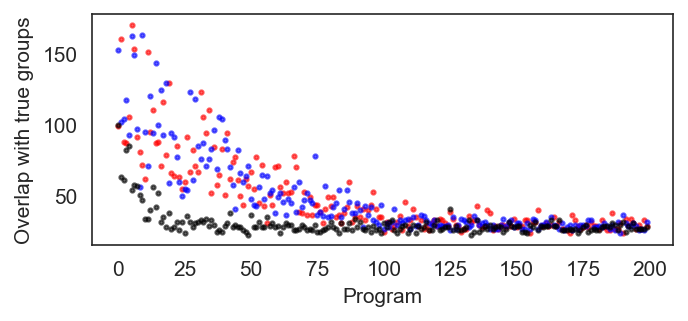

In [14]:
# compare topK programs to true groups
k = 2000 // networks.loc[ix,'k']
prog_genes50_b1 = np.argpartition(sim_base_V**2, -k, axis=0)[-k:,:]
prog_genes50_b2 = np.argpartition(sim_base_V2**2, -k, axis=0)[-k:,:]
prog_genes50_p1 = np.argpartition(sim_ps_V**2, -k, axis=0)[-k:,:]
prog_genes50_p2 = np.argpartition(sim_ps_V2**2, -k, axis=0)[-k:,:]

fig, ax = plt.subplots(1, 1, figsize=(5,2), dpi=150)
ax.plot(*zip(*enumerate([max([sum(np.in1d(np.arange(sim_ps_V.shape[0]), prog_genes50_p1[:,i]) & (group[ix]==j)) for j in range(max(group[ix])+1)]) for i in range(n_components)])), 'r.', alpha=0.6, ms=4, label='Perturbation data (1)');
ax.plot(*zip(*enumerate([max([sum(np.in1d(np.arange(sim_ps_V2.shape[0]), prog_genes50_p2[:,i]) & (group[ix]==j)) for j in range(max(group[ix])+1)]) for i in range(n_components)])), 'b.', alpha=0.6, ms=4, label='Perturbation data (2)');
ax.plot(*zip(*enumerate([max([sum(np.in1d(np.arange(sim_base_V.shape[0]), prog_genes50_b1[:,i]) & (group[ix]==j)) for j in range(max(group[ix])+1)]) for i in range(n_components)])), 'k.', alpha=0.6, ms=4, label='Baseline data');

ax.set_xlabel('Program');
ax.set_ylabel('Overlap with true groups');

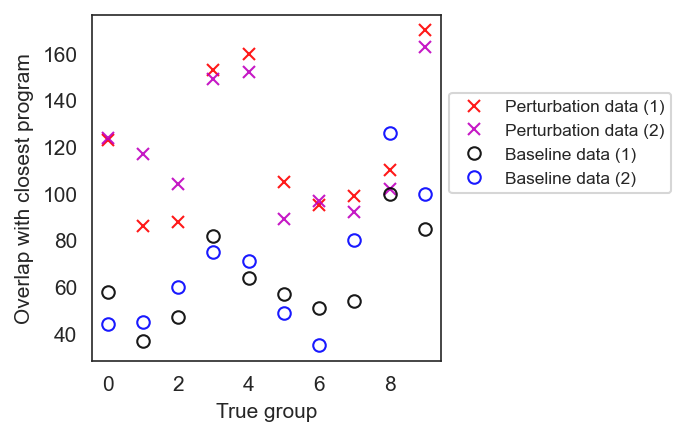

In [15]:
# compare topK programs to true groups, the other way

fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=150)
ax.plot(*zip(*enumerate([max([sum(np.in1d(np.arange(sim_ps_V.shape[0]), prog_genes50_p1[:,i]) & (group[ix]==j)) for i in range(n_components)]) for j in range(max(group[ix])+1)])), 
        'rx', fillstyle='none', alpha=0.9, ms=6, label='Perturbation data (1)');
ax.plot(*zip(*enumerate([max([sum(np.in1d(np.arange(sim_ps_V2.shape[0]), prog_genes50_p2[:,i]) & (group[ix]==j)) for i in range(n_components)]) for j in range(max(group[ix])+1)])), 
        'mx', fillstyle='none', alpha=0.9, ms=6, label='Perturbation data (2)');
ax.plot(*zip(*enumerate([max([sum(np.in1d(np.arange(sim_base_V.shape[0]), prog_genes50_b1[:,i]) & (group[ix]==j)) for i in range(n_components)]) for j in range(max(group[ix])+1)])), 
        'ko', fillstyle='none', alpha=0.9, ms=6, label='Baseline data (1)');
ax.plot(*zip(*enumerate([max([sum(np.in1d(np.arange(sim_base_V2.shape[0]), prog_genes50_b2[:,i]) & (group[ix]==j)) for i in range(n_components)]) for j in range(max(group[ix])+1)])), 
        'bo', fillstyle='none', alpha=0.9, ms=6, label='Baseline data (2)');

ax.set_xlabel('True group');
ax.set_ylabel('Overlap with closest program');
ax.legend(fontsize='small', bbox_to_anchor=(1, 0.8));

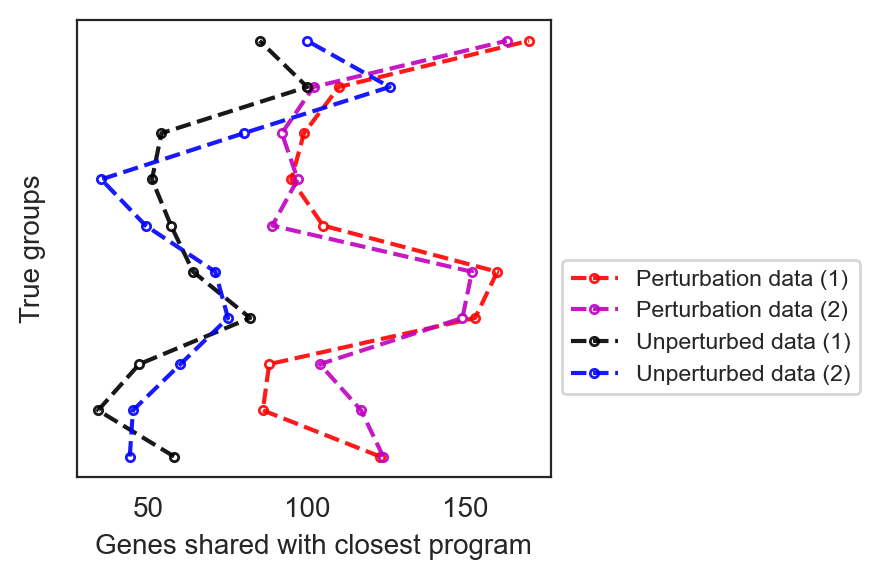

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4.5,3), dpi=200)
#order=[4,9,3,1,0,6,7,5,8,2][::-1]
order=list(range(networks.loc[ix].k))
ax.plot(*zip(*map(reversed,enumerate([max([sum(np.in1d(np.arange(sim_ps_V.shape[0]), prog_genes50_p1[:,i]) & (group[ix]==j)) for i in range(50)]) for j in order]))), 
        'r.--', fillstyle='none', alpha=0.9, ms=6, label='Perturbation data (1)');
ax.plot(*zip(*map(reversed,enumerate([max([sum(np.in1d(np.arange(sim_ps_V2.shape[0]), prog_genes50_p2[:,i]) & (group[ix]==j)) for i in range(50)]) for j in order]))), 
        'm.--', fillstyle='none', alpha=0.9, ms=6, label='Perturbation data (2)');
ax.plot(*zip(*map(reversed,enumerate([max([sum(np.in1d(np.arange(sim_base_V.shape[0]), prog_genes50_b1[:,i]) & (group[ix]==j)) for i in range(50)]) for j in order]))), 
        'k.--', fillstyle='none', alpha=0.9, ms=6, label='Unperturbed data (1)');
ax.plot(*zip(*map(reversed,enumerate([max([sum(np.in1d(np.arange(sim_base_V2.shape[0]), prog_genes50_b2[:,i]) & (group[ix]==j)) for i in range(50)]) for j in order]))), 
        'b.--', fillstyle='none', alpha=0.9, ms=6, label='Unperturbed data (2)');

ax.set_ylabel('True groups');
ax.set_yticks(range(10)); ax.set_yticklabels(['' for _ in ax.get_yticklabels()]);
ax.set_xlabel('Genes shared with closest program');
ax.legend(fontsize='small', bbox_to_anchor=(1, 0.5));

plt.tight_layout()

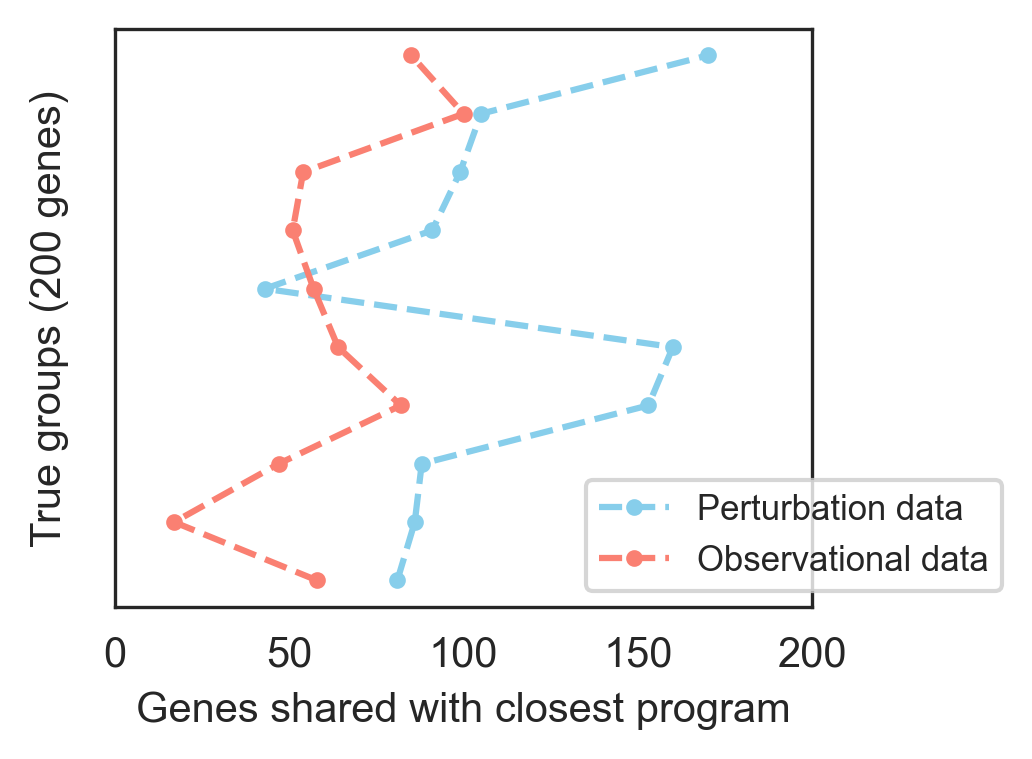

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3,2.5), dpi=300)
#order=[4,9,3,1,0,6,7,5,8,2][::-1]
ax.plot(*zip(*map(reversed,enumerate([max([sum(np.in1d(np.arange(sim_ps_V.shape[0]), prog_genes50_p1[:,i]) & (group[ix]==j)) for i in range(networks.loc[ix,'k'])]) for j in order]))), 
        '.--', color='skyblue', fillstyle='full', alpha=1.0, ms=6, label='Perturbation data');
ax.plot(*zip(*map(reversed,enumerate([max([sum(np.in1d(np.arange(sim_base_V.shape[0]), prog_genes50_b1[:,i]) & (group[ix]==j)) for i in range(networks.loc[ix,'k'])]) for j in order]))), 
        '.--', color='salmon', fillstyle='full', alpha=1.0, ms=6, label='Observational data');

ax.set_ylabel('True groups (200 genes)');
ax.set_yticks(range(10)); ax.set_yticklabels(['' for _ in ax.get_yticklabels()]);
ax.set_xlabel('Genes shared with closest program');
ax.set_xlim(0, 2000/networks.loc[ix].k);
ax.legend(fontsize='small', bbox_to_anchor=(0.65, 0.25));

# Supplement

In [18]:
df = pd.DataFrame({'Perturbation data': [max([sum(np.in1d(np.arange(sim_ps_V.shape[0]), 
                                                                   prog_genes50_p1[:,i]) 
                                                           & (group[ix]==j)
                                                          ) for i in range(50)]) for j in order],
                   'Unperturbed data': [max([sum(np.in1d(np.arange(sim_ps_V.shape[0]), 
                                                                   prog_genes50_b1[:,i]) 
                                                           & (group[ix]==j)
                                                          ) for i in range(50)]) for j in order]})

## A: Overlap with true groups

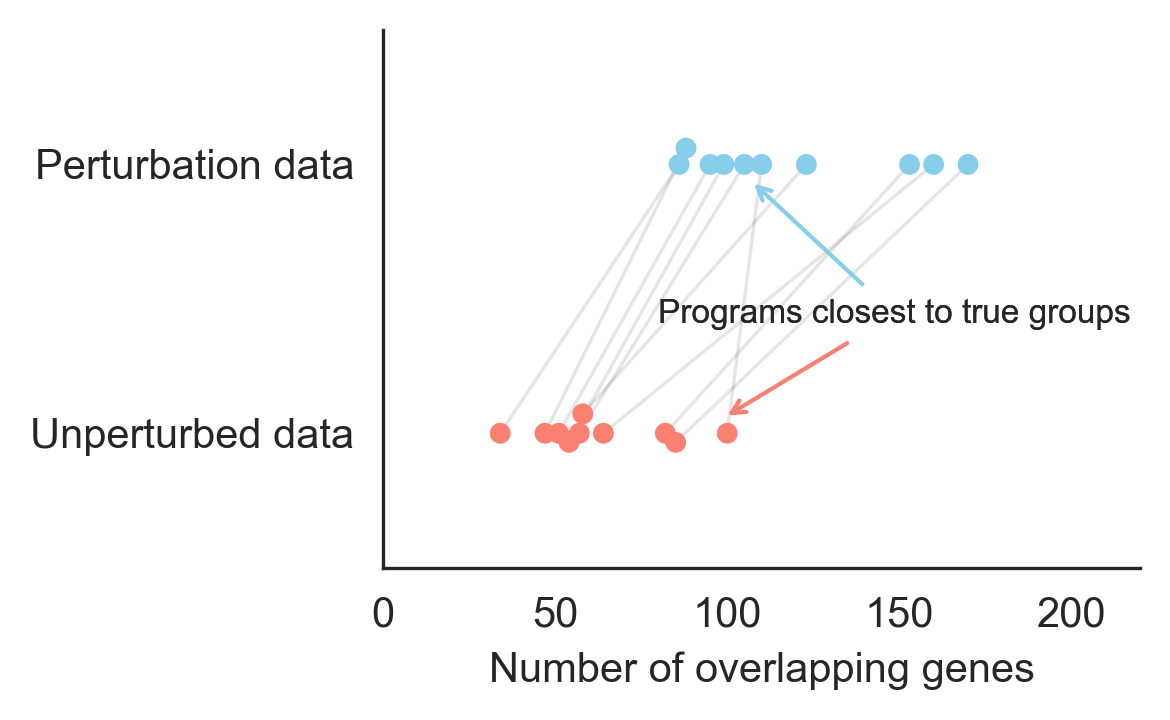

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4,2.5), dpi=300)

sns.swarmplot(data=pd.melt(df), y='variable', x='value', palette=['skyblue','salmon'], ax=ax)
ax.set_xlim(0, 1.1*2000/networks.loc[ix].k);
ax.set_xlabel('Number of overlapping genes');
ax.set_ylabel('');
#ax.set_title('GRN with 10 groups');
sns.despine()

ax.annotate('Programs closest to true groups', xy=(0.53*2000/networks.loc[ix].k,0.05), xytext=(80, 0.5), # (2.2, 6e-5), (0.9e-4, 6e-5)
            fontsize=8, va='top', 
            arrowprops=dict(arrowstyle='->', facecolor='skyblue', edgecolor='skyblue')
            #arrowprops=dict(facecolor='blue', width=1, headlength=0.1, headwidth=0.1, shrink=0.1),
            );

ax.annotate('Programs closest to true groups', xy=(0.49*2000/networks.loc[ix].k,0.95), xytext=(80, 0.5), # (2.2, 6e-5), (0.9e-4, 6e-5)
            fontsize=8, va='top', 
            arrowprops=dict(arrowstyle='->', facecolor='salmon', edgecolor='salmon')
            #arrowprops=dict(facecolor='blue', width=1, headlength=0.1, headwidth=0.1, shrink=0.1),
            );

lines=True
if lines:
    idx0 = 0
    idx1 = 1
    locs1 = ax.get_children()[idx0].get_offsets()
    locs2 = ax.get_children()[idx1].get_offsets()
    
    # before plotting, we need to sort so that the data points
    # correspond to each other as they did in "set1" and "set2"
    sort_idxs1 = np.argsort(df.iloc[:,0])
    sort_idxs2 = np.argsort(df.iloc[:,1])
    
    # revert "ascending sort" through sort_idxs2.argsort(),
    # and then sort into order corresponding with set1
    locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]
    
    for i in range(locs1.shape[0]):
        x = [locs1[i, 0], locs2_sorted[i, 0]]
        y = [locs1[i, 1], locs2_sorted[i, 1]]
        ax.plot(x, y, color="black", alpha=0.1, linewidth=0.8)

plt.tight_layout();
plt.savefig('png/supplement/fig_s7a.png');

## B: Replogle downsample

In [20]:
# front matter: load data, get relevant information
z_ds = {n_ds: np.load('figdata/fig7.replogle.sup_ds.{}.tsvd.npz'.format(n_ds)) for n_ds in map(int, [1e4,3e4,1e5,3e5,len(cell_ix)])}
z_ds[n_ctrl_cells] = np.load('figdata/fig7.replogle.ds1.tsvd.npz')
z_ds[str(n_ctrl_cells)+'ctrl'] = np.load('figdata/fig7.replogle.ctrl.tsvd.npz')

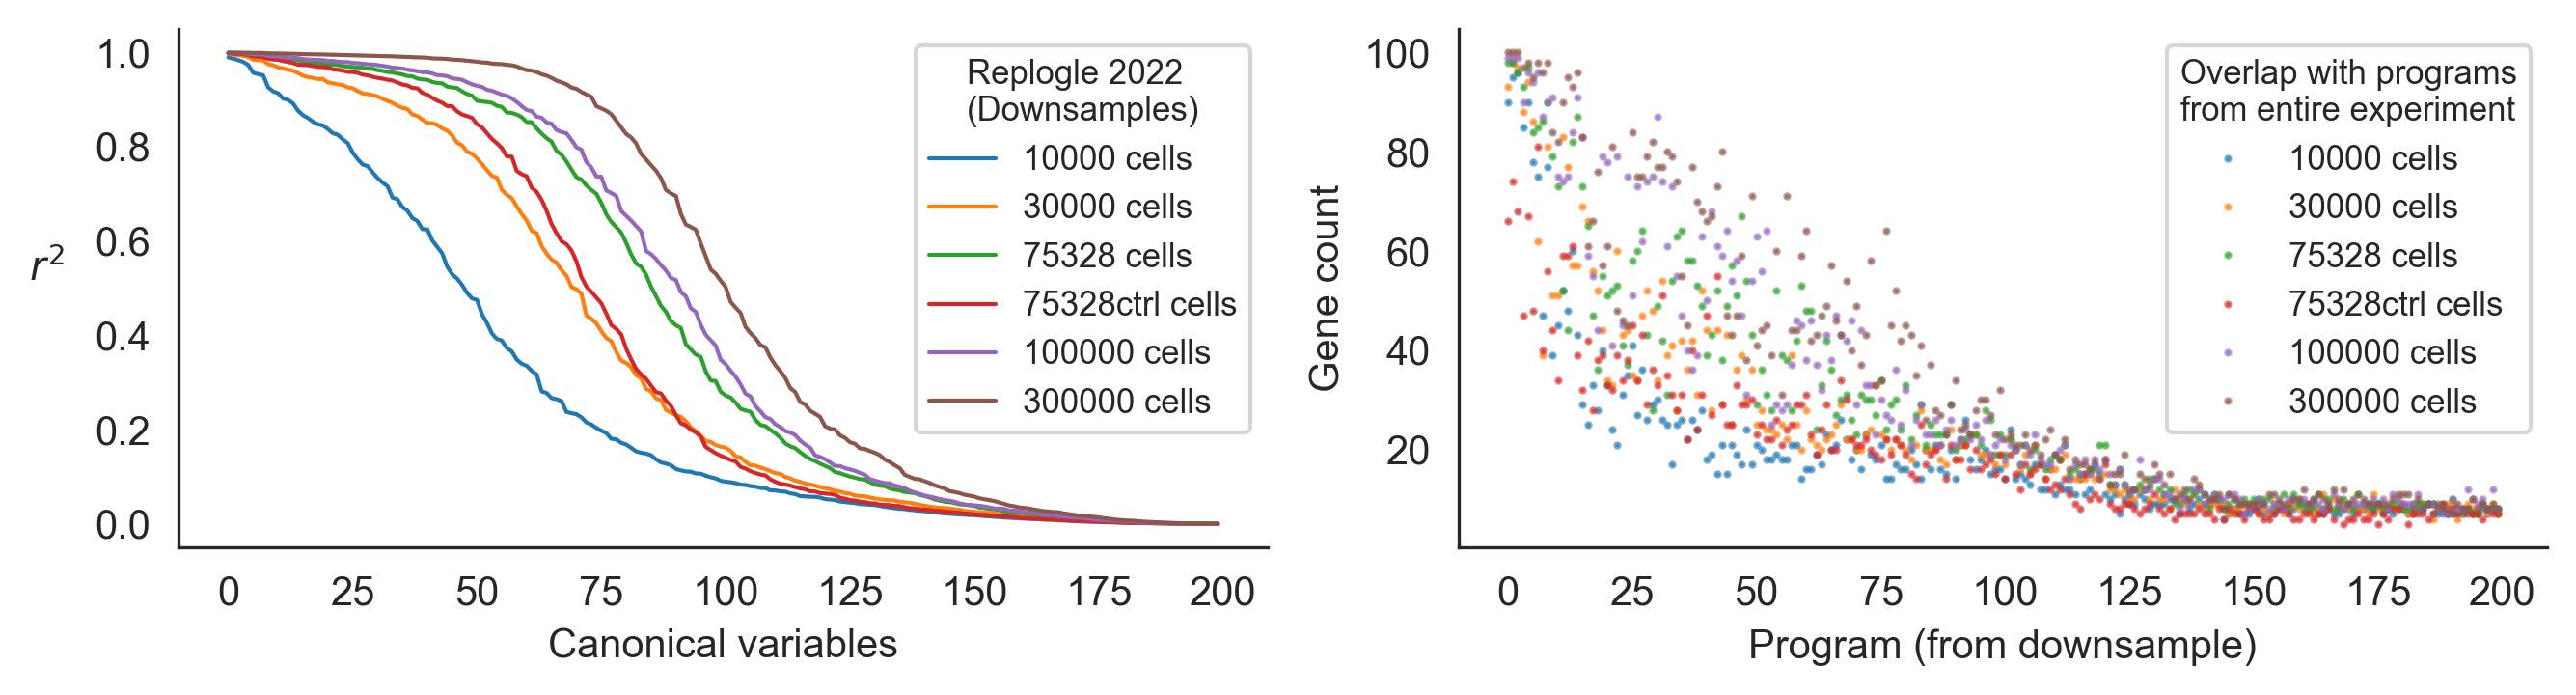

In [21]:
# figure
fig, ax = plt.subplots(1, 2, figsize=(9,2.5), dpi=300)

# define programs of size k, from the top c components
k=100
c=z_ds[len(cell_ix)]['D'].shape[0] 
loadings = z_ds[len(cell_ix)]['V']
programs = np.argpartition(loadings**2, -k, axis=0)[-k:,:]

# compare downsamples to entire experiment
for n_ds in [10000,30000,n_ctrl_cells,str(n_ctrl_cells)+'ctrl',100000,300000]:
    # canonical correlation
    ax[0].plot(*zip(*enumerate(np.linalg.svd(loadings.T.dot(z_ds[n_ds]['V']), 0)[1]**2)), 
               linestyle='solid', 
               linewidth=1,
               label='{} cells'.format(n_ds))

    # overlap with closest program
    p2 = np.argpartition(z_ds[n_ds]['V']**2, -k, axis=0)[-k:,:]
    ax[1].plot(*zip(*enumerate([max([len(set(programs[:,i]) & set(p2[:,j])) for j in range(c)]) for i in range(c)])), 
               marker='.',
               linestyle='none',
               alpha=0.6,
               ms=2,
               label='{} cells'.format(n_ds))

# labels for canonical correlation
ax[0].legend(fontsize='small', title='Replogle 2022\n(Downsamples)', title_fontsize='small');
ax[0].set_xlabel('Canonical variables')
ax[0].set_ylabel(r'$r^2$', rotation=0, labelpad=12);

# labels for overlap with closest program
ax[1].set_xlabel('Program (from downsample)')
ax[1].set_ylabel('Gene count')
ax[1].legend(fontsize='small', title='Overlap with programs\nfrom entire experiment', title_fontsize='small')

sns.despine();
plt.tight_layout();
plt.savefig('png/supplement/fig_s7b.png');

## C: Noise titration

7it [00:40,  5.84s/it]


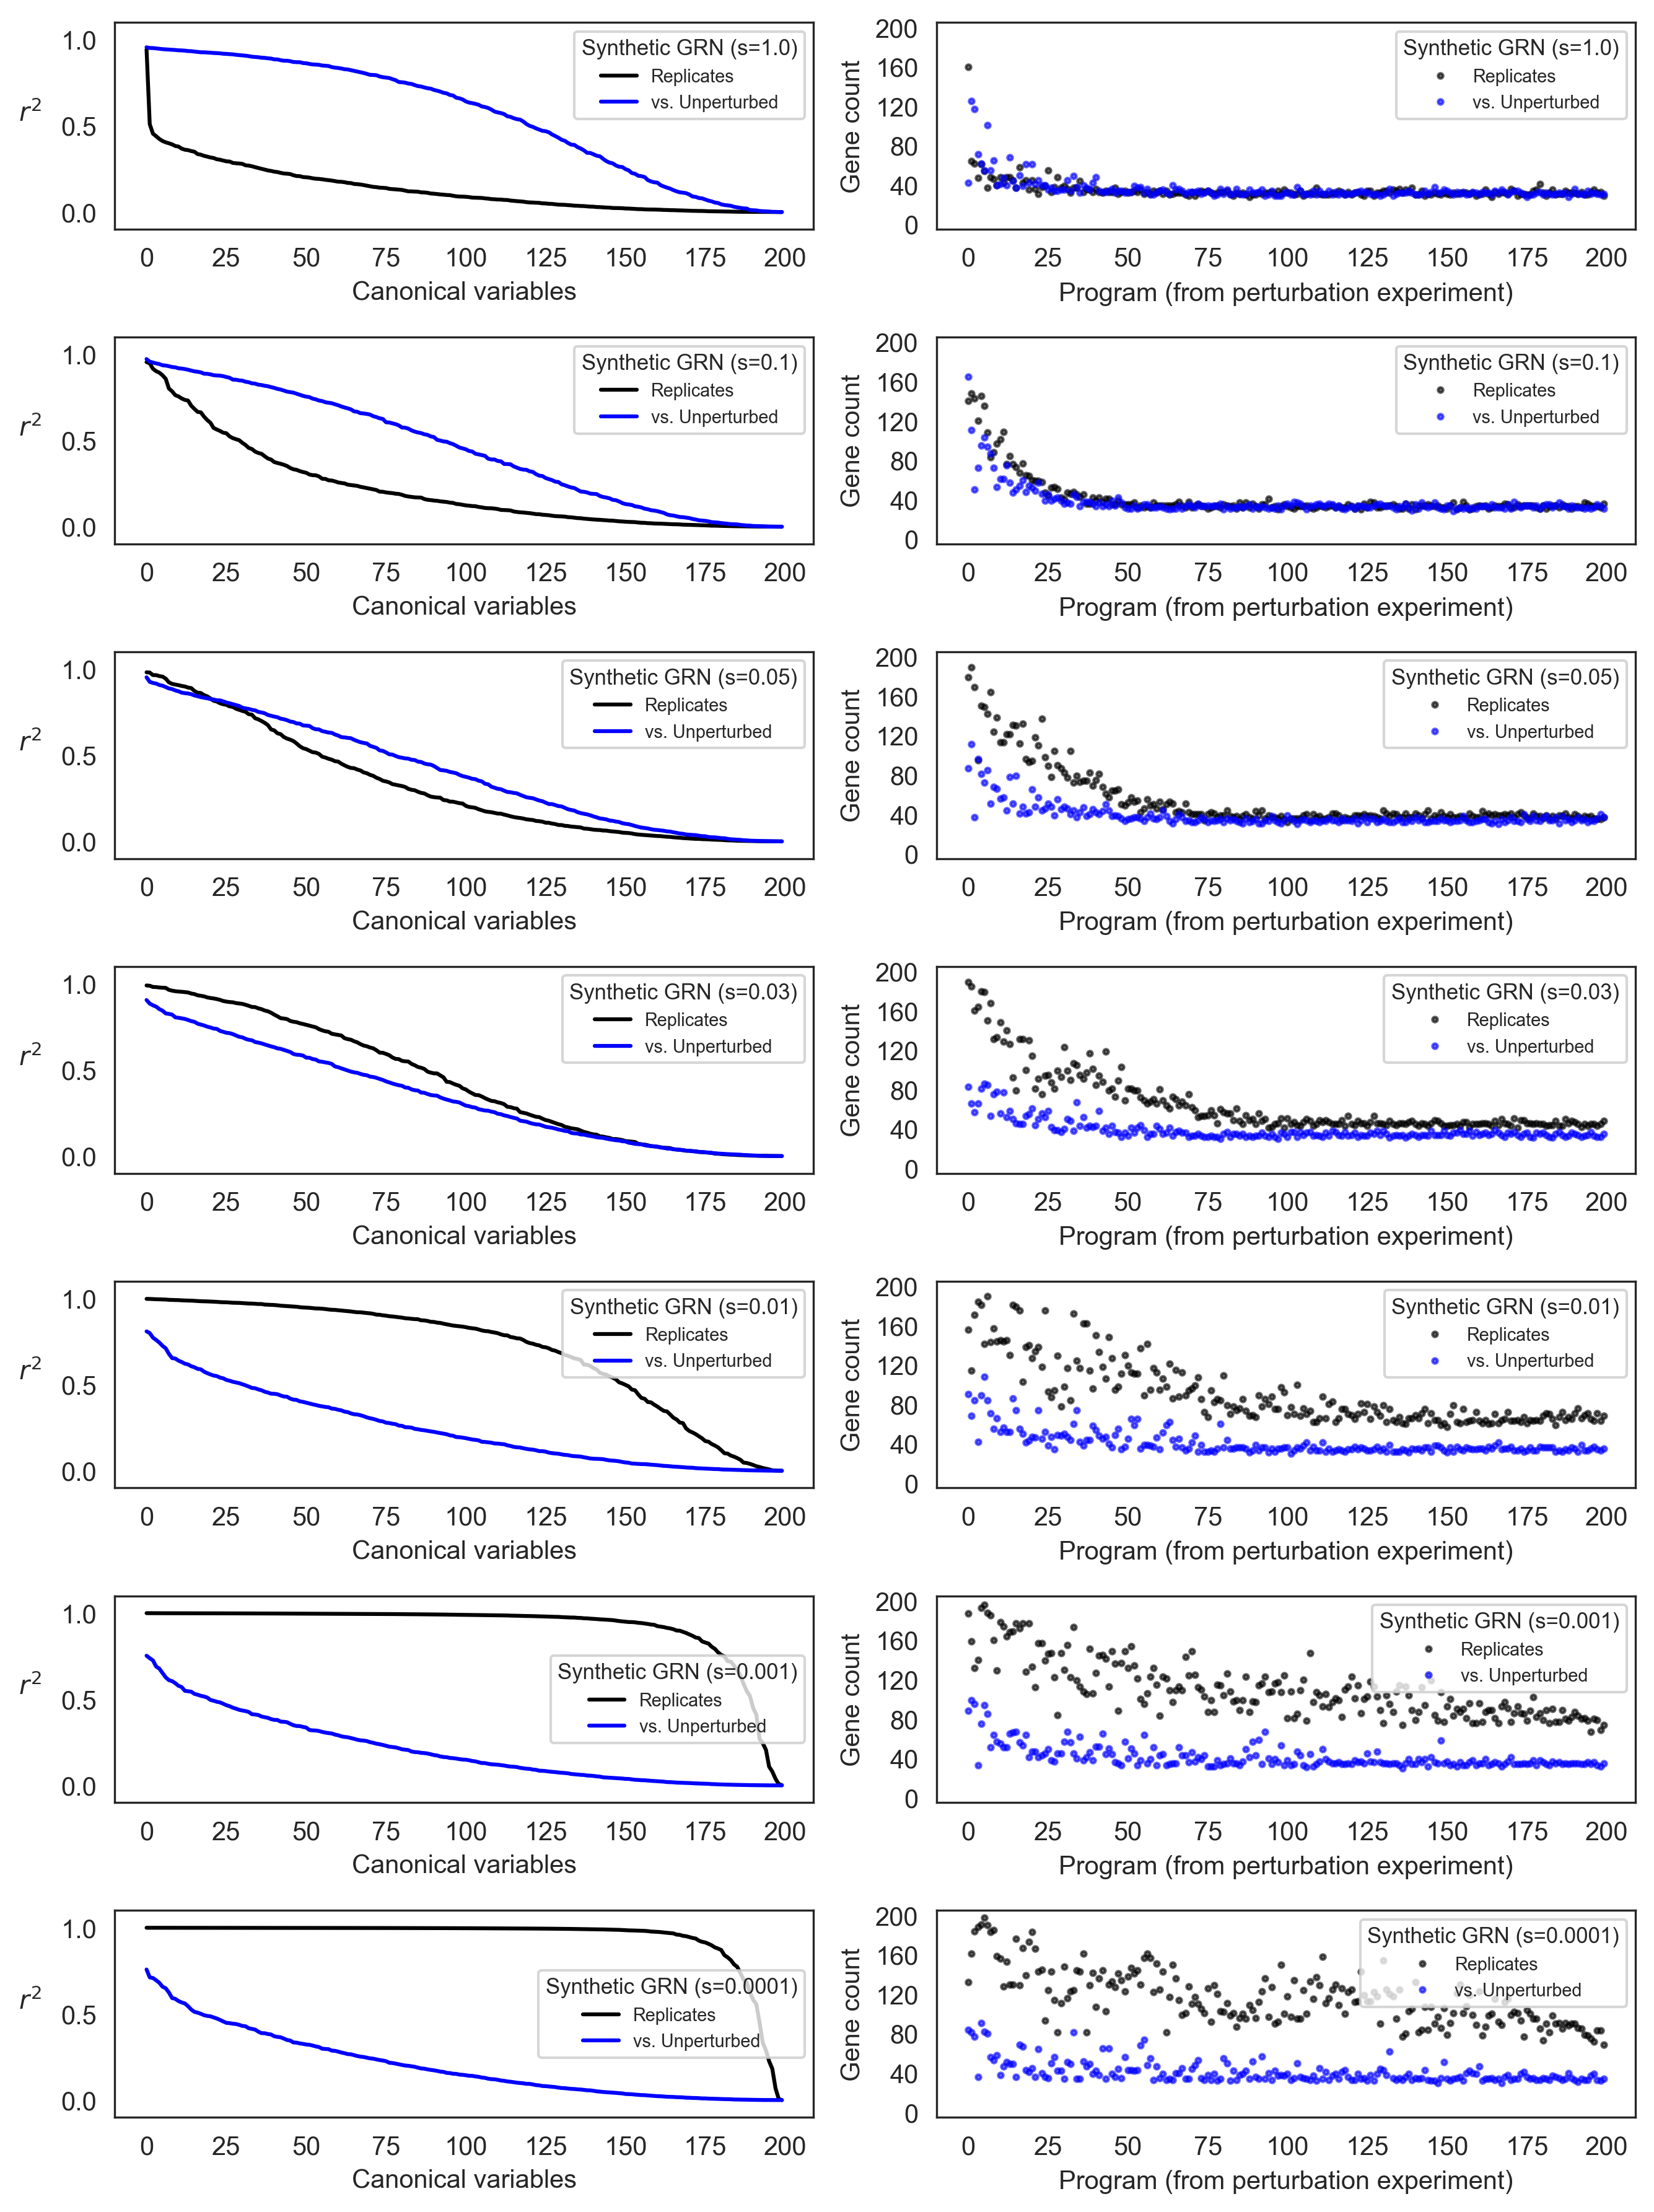

In [22]:
sns.set_style('white'); 

fig = plt.figure(figsize=(9,12), dpi=200)

grid = gs.GridSpec(14, 8, figure=fig)

npc=100

for i,s in tqdm(enumerate([1e0, 1e-1, 5e-2, 3e-2, 1e-2, 1e-3, 1e-4])):
    z = np.load('figdata/fig7.baseline_cells.{0}.{1}.tsvd.npz'.format(ix, s))
    sim_base_U = z['U']
    sim_base_D = z['D']
    sim_base_V = z['V']
    
    z = np.load('figdata/fig7.baseline_cells.{0}.{1}.2.tsvd.npz'.format(ix, s))
    sim_base_U2 = z['U']
    sim_base_D2 = z['D']
    sim_base_V2 = z['V']
    
    z = np.load('figdata/fig7.ko_cells.{0}.{1}.tsvd.npz'.format(ix, s))
    sim_ps_U = z['U']
    sim_ps_D = z['D']
    sim_ps_V = z['V']
    
    z = np.load('figdata/fig7.ko_cells.{0}.{1}.2.tsvd.npz'.format(ix, s))
    sim_ps_U2 = z['U']
    sim_ps_D2 = z['D']
    sim_ps_V2 = z['V']
    
    ax0 = fig.add_subplot(grid[2*i:2*(i+1),0:4])
    ax0.plot(*zip(*enumerate(np.linalg.svd(sim_ps_V.T.dot(sim_ps_V2), 0)[1]**2)), 'k-',
            label='Replicates')
    ax0.plot(*zip(*enumerate(np.linalg.svd(sim_ps_V.T.dot(sim_base_V), 0)[1]**2)), 'b-',
            label='vs. Unperturbed')
    ax0.legend(fontsize='x-small', title='Synthetic GRN (s={})'.format(s), title_fontsize='small', frameon=1);
    ax0.set_xlabel('Canonical variables'); 
    ax0.set_ylabel(r'$r^2$', rotation=0, labelpad=12);
    ax0.set_ylim(-0.1, 1.1);

    k = int(2000/networks.loc[ix,'k'])
    ax = [None]
    ax[0] = fig.add_subplot(grid[2*i:2*(i+1), 4:8])
    prog_genes50_b1 = np.argpartition(sim_base_V**2, -k, axis=0)[-k:,:]
    prog_genes50_b2 = np.argpartition(sim_base_V2**2, -k, axis=0)[-k:,:]
    prog_genes50_p1 = np.argpartition(sim_ps_V**2, -k, axis=0)[-k:,:]
    prog_genes50_p2 = np.argpartition(sim_ps_V2**2, -k, axis=0)[-k:,:]
    
    ax[0].plot(*zip(*enumerate([max([len(set(prog_genes50_p1[:,i]) & set(prog_genes50_p2[:,j])) for j in range(n_components)]) for i in range(n_components)])), 
               'k.', alpha=0.6, ms=4, label='Replicates');
    ax[0].plot(*zip(*enumerate([max([len(set(prog_genes50_p1[:,i]) & set(prog_genes50_b1[:,j])) for j in range(n_components)]) for i in range(n_components)])), 
               'b.', alpha=0.6, ms=4, label='vs. Unperturbed');
    ax[0].set_xlabel('Program (from perturbation experiment)');
    ax[0].set_ylabel('Gene count');
    ax[0].legend(fontsize='x-small', title='Synthetic GRN (s={})'.format(s), title_fontsize='small', frameon=1);
    ax[0].set_ylim(-5,k+5); ax[0].set_yticks(np.arange(0, k + 1, (k + 1) // 5));

fig.tight_layout();
plt.savefig('png/supplement/fig_s7c.png');